# Medical Label Project

## Setting up

Import necessary packages and adjust settings.

In [374]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.options.mode.chained_assignment = None  # default='warn'

Read data from csv files.

In [287]:
reads = pd.read_csv('data/1345_admin_reads.csv')
results = pd.read_csv('data/1345_customer_results.csv',index_col="Case ID")

Throw out all rows which do not end with voteN for N=0-8 in the "Origin" column of the results dataframe, and extract N from the column for the remaining data.\
N is the number of experts who voted 'yes'.

In [288]:
valid_vote = results["Origin"].str.fullmatch(r'(.*)vote[0-8](.*)', case=False)
valid_results = results.loc[valid_vote]
votes = valid_results["Origin"].str.extract(r'vote(\d)').astype(int)

Throw out unnecessary columns. Create a new row called "Votes" to store the number of votes extracted from the "Origin".

In [289]:
reads=reads.loc[:,["problem_id", "accuracy","chosen_answer"]]
reads["chosen_answer"]=reads["chosen_answer"].str.extract(r'\[(.*)\]')
valid_results = valid_results.loc[:,"Qualified Reads":"Second Choice Weight"]
valid_results["Votes"] = votes
reads

,problem_id,accuracy,chosen_answer
0,5888087,0.78,'no'
1,5888087,0.76,'no'
2,5888088,0.78,'no'
3,5888088,0.80,'no'
4,5888088,0.76,'no'
...,...,...,...
152055,5918379,0.82,'yes'
152056,5918379,0.78,'yes'
152057,5918379,0.84,'yes'
152058,5918379,0.76,'yes'


## Remarks on "Correct Label"

By interpreting number of votes<4 as having a correct label of 'no', number of votes>4 as having a correct label of 'yes', and having no correct label otherwise, this column completely agrees with the "Correct Label" column.

In [290]:
print("Correct Labels corresponding to < 4 votes:", valid_results.loc[valid_results["Votes"]<4,"Correct Label"].unique())
print("Correct Labels corresponding to > 4 votes:", valid_results.loc[valid_results["Votes"]>4,"Correct Label"].unique())
print("Correct Labels corresponding to = 4 votes:", valid_results.loc[valid_results["Votes"]==4,"Correct Label"].unique())

Correct Labels corresponding to < 4 votes: ["'no'"]
Correct Labels corresponding to > 4 votes: ["'yes'"]
Correct Labels corresponding to = 4 votes: [nan]


We also note that out of the 27000 results, 12000 of them have a correct label of 'no', 12000 of them have a correct label of 'yes', and 3000 of them have no correct label.

In [291]:
print(valid_results["Correct Label"].value_counts(dropna=False))

'no'     12000
'yes'    12000
NaN       3000
Name: Correct Label, dtype: int64


## Remark on "Majority Label"

Out of the 27000 results, 14547 of them have a majority label of 'no', 12211 of them have a majority label of 'yes', and 242 of them have no majority label.

In [292]:
print(valid_results["Majority Label"].value_counts(dropna=False))

'yes'    14547
'no'     12211
NaN        242
Name: Majority Label, dtype: int64


The reason that 242 of them have no majority labels is that all of them have no qualified reads.

In [293]:
print(valid_results.loc[valid_results["Majority Label"].isna(),"Qualified Reads"].value_counts())

0    242
Name: Qualified Reads, dtype: int64


Of the results with at least one qualified reads, 1580 of them have an equal number of yes/no votes. In these cases, the majority label is determined by the sum of accuracy score of qualified reads for each choice answer.

In [294]:
print(valid_results.loc[(valid_results["First Choice Votes"]==valid_results["Second Choice Votes"])&(valid_results["Qualified Reads"]!=0),"Majority Label"].value_counts(dropna=False))

'no'     764
'yes'    744
Name: Majority Label, dtype: int64


## Analysis

We first count the number of expert who agrees with expert majority and the total number of expert votes.\
The since each result have 8 expert votes, the total number is simply calculated by 8 times the number of results.\
The problem is that as we've seen earlier, some results have no expert majority because equal number of experts voted on yes vs no, so we need to decide whether to include these results. I'd like to argue that since there have to be a correct label (though we don't know which), we can say that 50% of the experts got the correct answer in these cases, so the result can be included.\
Then the number is calculated by summing over the number of votes on the majority label.

In [295]:
num_expert_agree = (np.max((valid_results["Votes"],8-valid_results["Votes"]),axis=0)).sum()
total_expert_votes = len(valid_results.index) * 8
num_expert_agree/total_expert_votes

0.7777777777777778

Then we do the same for the crowd votes.\
Note that there are some cases where the first choice answer is not the same as majority label since there were an equal number of first choice answers and second choice answers, but we can safely use the number of votes on the first choice answer in our calculation of votes that agreed with the correct label since the votes on the two answers are the same.

In [296]:
total_crowd_votes = (valid_results["Qualified Reads"]).sum()

# Descriptive Analysis
We will try to prove that the crowd agree with the expert majority more often than experts agreeing with the expert majority.

In the following table, we calculated the median agreement rate of the crowd among themselves and with the experts, grouped by the agreement rate among experts. The first column is the agreement rate among crowd, the second is the accuracy of the crowd (rate that the label they gave coincide with expert majority), the last is the agreement among experts. We can see that in all cases, the agreement rate among crowd is at least as high as the agreement rate among experts, and of the cases where a correct label has been determined by the expert majority, 7 out of 8 times the crowd accuracy is higher than accuracy of experts.

In [362]:
agreement_df = valid_results.groupby("Votes")[["Agreement", "Difficulty"]].median()
agreement_df["Difficulty"] = 1-agreement_df["Difficulty"]
expert_agreement=np.max([1-np.arange(0,1.01,1/8), np.arange(0,1.01,1/8)],axis=0)
agreement_df["Expert Agreement"] = expert_agreement
agreement_df.rename(columns={"Difficulty":"Crowd Accuracy","Agreement":"Crowd Agreement"},inplace=True)
agreement_df

,Crowd Agreement,Crowd Accuracy,Expert Agreement
Votes,,,
0,1.000,1.000,1.000
1,1.000,0.857,0.875
2,1.000,0.800,0.750
3,1.000,0.667,0.625
4,0.857,NaN,0.500
5,1.000,0.778,0.625
6,1.000,1.000,0.750
7,1.000,1.000,0.875
8,1.000,1.000,1.000


The plot below provides a visualization of the previous table. As we can see in the plot, the blue bars and orange bars are usually higher than the green bars, meaning that the agreement and accuracy of the crowd is higher than the agreement among experts.

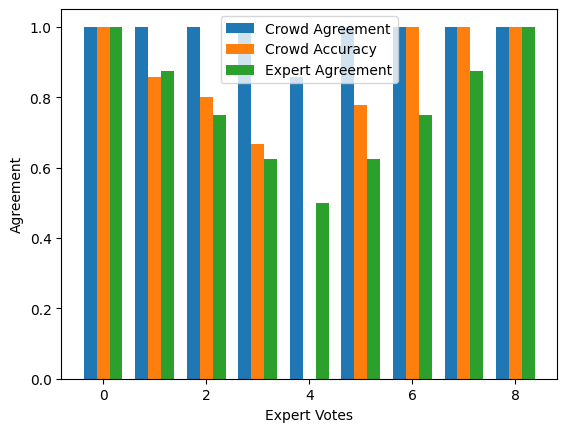

In [373]:
fig = plt.figure()
ax = fig.add_subplot(111)
w=1/4
ax.bar(agreement_df.index-3/2*w,agreement_df["Crowd Agreement"],w,align='edge',label="Crowd Agreement")
ax.bar(agreement_df.index-w/2,agreement_df["Crowd Accuracy"],w,align='edge',label="Crowd Accuracy")
ax.bar(agreement_df.index+w/2,agreement_df["Expert Agreement"],w,align='edge',label="Expert Agreement")
plt.xlabel("Expert Votes")
plt.ylabel("Agreement")
plt.legend()

The next table shows the percentage of cases of which the crowd accuracy rate is at least as high as the experts. This percentage is 0 for cases where expert agreement is 0.5 because since there's no "correct label" given, we do not have the crowd accuracy rate. For the rest of cases, we can see that when expert agreement rate is 0.625, the crowd had an equal or higher accuracy rate on **57%** of the cases; when expert agreement rate is 0.75, the crowd had an equal or higher accuracy rate on **62%** of the cases; when expert agreement rate is 0.875, the crowd had an equal or higher accuracy rate on **56%** of the cases; when experts are unanimous, the crowd had an equal or higher accuracy rate on **72%** of the cases. From these data, we can conclude that the crowd usually agrees with expert majorities more than experts do. 

In [434]:
df=pd.DataFrame()
df["percentage"]=(1-valid_results["Difficulty"])>=np.max([valid_results["Votes"],8-valid_results["Votes"]],axis=0)/8
df["Expert Agreement"]=np.max([valid_results["Votes"],8-valid_results["Votes"]],axis=0)/8
df.groupby(["Expert Agreement"]).mean()

,percentage
Expert Agreement,
0.500,0.000000
0.625,0.572000
0.750,0.622167
0.875,0.564167
1.000,0.718500


Below is the t-test on whether the mean of crowd accuracy is higher than the experts' accuracy. This result is significant only for cases where number of expert votes is 5 or 6.

In [441]:
d = [1-valid_results.loc[valid_results["Votes"]==i,"Difficulty"] for i in range(9)]
res = stats.ttest_1samp(d,popmean=expert_agreement,axis=1,nan_policy="omit",alternative="greater")
res.pvalue.data < 0.01

array([False, False, False, False, False,  True,  True, False, False])

In [442]:
stats.ttest_1samp(valid_results["Agreement"],popmean=np.mean(expert_agreement),nan_policy="omit",alternative="greater")

Ttest_1sampResult(statistic=103.47184760240071, pvalue=0.0)

Below is the t-test on whether the mean of crowd agreement rate among themselves is higher than the experts. This result is significant for cases where number of expert votes is between 2 and 7.

In [440]:
d = [valid_results.loc[valid_results["Votes"]==i,"Agreement"] for i in range(9)]
res = stats.ttest_1samp(d,popmean=expert_agreement,axis=1,nan_policy="omit",alternative="greater")
res.pvalue.data < 0.01

array([False, False,  True,  True,  True,  True,  True,  True, False])